# Linear regression. Part 1

---

## Linear and Logistic Regressions: prediction and metrics


Applied Mathematical Modeling in Banking

---

# 1. Dataset overview

У даному навчальному матеріалі використано класичний приклад даних з інформацією про престижність професій у Канаді 1971 року. Джерело: carData::Prestige.

In [3]:
install.packages("carData")
library(carData)

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [4]:
data <- carData::Prestige
head(data)

,education,income,women,prestige,census,type
,<dbl>,<int>,<dbl>,<dbl>,<int>,<fct>
gov.administrators,13.11,12351,11.16,68.8,1113,prof
general.managers,12.26,25879,4.02,69.1,1130,prof
accountants,12.77,9271,15.70,63.4,1171,prof
purchasing.officers,11.42,8865,9.11,56.8,1175,prof
chemists,14.62,8403,11.68,73.5,2111,prof
physicists,15.64,11030,5.13,77.6,2113,prof


Переглянемо структуру даних:

In [6]:
str(data)

'data.frame':	102 obs. of  6 variables:
 $ education: num  13.1 12.3 12.8 11.4 14.6 ...
 $ income   : int  12351 25879 9271 8865 8403 11030 8258 14163 11377 11023 ...
 $ women    : num  11.16 4.02 15.7 9.11 11.68 ...
 $ prestige : num  68.8 69.1 63.4 56.8 73.5 77.6 72.6 78.1 73.1 68.8 ...
 $ census   : int  1113 1130 1171 1175 2111 2113 2133 2141 2143 2153 ...
 $ type     : Factor w/ 3 levels "bc","prof","wc": 2 2 2 2 2 2 2 2 2 2 ...


Значення показників вибірки:

- [x] prestige – престиж професії за Pineo-Porter score, на основі дослідження середини 1960-х. **It is target!!!**
- [x] education - середня кількість років освіти.
- [x] income – середній дохід респондентів, дол.
- [x] women – частка жінок у галузі
- [x] census – канадський код професії.
- [x] type – тип професії: bc, Blue Collar; prof, Professional, Managerial, and Technical; wc, White Collar.

Оглянемо описову статистику факторів:

In [7]:
summary(data)

   education          income          women           prestige    
 Min.   : 6.380   Min.   :  611   Min.   : 0.000   Min.   :14.80  
 1st Qu.: 8.445   1st Qu.: 4106   1st Qu.: 3.592   1st Qu.:35.23  
 Median :10.540   Median : 5930   Median :13.600   Median :43.60  
 Mean   :10.738   Mean   : 6798   Mean   :28.979   Mean   :46.83  
 3rd Qu.:12.648   3rd Qu.: 8187   3rd Qu.:52.203   3rd Qu.:59.27  
 Max.   :15.970   Max.   :25879   Max.   :97.510   Max.   :87.20  
     census       type   
 Min.   :1113   bc  :44  
 1st Qu.:3120   prof:31  
 Median :5135   wc  :23  
 Mean   :5402   NA's: 4  
 3rd Qu.:8312            
 Max.   :9517            

# 2. Train/Test split

Розділимо загальну вибірку на 2 частини: * тренувальна, 70% вибірки, для побудови регресії; * тестова, 30% вибірки, для перевірки точності моделі.

In [78]:
set.seed(10) #довільне число як точка "відправки" для генератора випадкових чисел

# Згенеруємо набір чисел від 1 до кількості спостережень у вибірці і відберемо випадквоим чином 70% із них
train_index <- sample(nrow(data), size = 0.7*nrow(data))

#Виведемо індекси (номери рядків) обраних для тренування даних
print(train_index)

 [1]   9  74  76  55  72  54  39  83  88  15  93  42  71 101  34  24  13   8   7
[20]  27  82  29  81  50  26  33  84  78  79  30  68  51  97  59  32  11  77  91
[39]  28  95  65  14  86  66  41  25  85  16  53  75  57  17  48  23  92  46  87
[58]  94   4  35  61  69  43  10  96  99  89  31  38  52  18


In [79]:
#Запишемо по номерах відібраних рядків тренувальний набір даних
train_data <- data[train_index, ]
head(train_data)

#Всі інші значення, що не увійшли в тренувальну вибірку запишемо у тестову
test_data <- data[-train_index, ]
head(test_data)

,education,income,women,prestige,census,type,income_2
,<dbl>,<int>,<dbl>,<dbl>,<int>,<fct>,<dbl>
civil.engineers,14.52,11377,1.03,73.1,2143,prof,129436129
textile.weavers,6.69,4443,31.36,33.3,8267,bc,19740249
tool.die.makers,10.09,8043,1.50,42.5,8311,bc,64689849
insurance.agents,11.60,8131,13.09,47.3,5171,wc,66113161
slaughterers.2,7.64,5134,17.26,34.8,8215,bc,26357956
service.station.attendant,9.93,2370,3.69,23.3,5145,bc,5616900


,education,income,women,prestige,census,type,income_2
,<dbl>,<int>,<dbl>,<dbl>,<int>,<fct>,<dbl>
gov.administrators,13.11,12351,11.16,68.8,1113,prof,152547201
general.managers,12.26,25879,4.02,69.1,1130,prof,669722641
accountants,12.77,9271,15.70,63.4,1171,prof,85951441
chemists,14.62,8403,11.68,73.5,2111,prof,70610409
physicists,15.64,11030,5.13,77.6,2113,prof,121660900
draughtsmen,12.30,7059,7.83,60.0,2163,prof,49829481


# 3. Short EDA (Exploratory data analysis)

## 3.1. Correlation

Переглянемо наявність зв’язків між параметрами за допоомгою матриці попарних кореляцій. Дані на перетині рядків вказують на рівень кореляції між вибраними показниками.

Виключимо змінну type, оскільки вона не має числового представлення:

In [12]:
cor(train_data[ ,-6])

,education,income,women,prestige,census
education,1.0000000,0.6243784,0.1507510,0.8448752,-0.8212488
income,0.6243784,1.0000000,-0.3910854,0.7425534,-0.3037354
women,0.1507510,-0.3910854,1.0000000,0.0227754,-0.3431387
prestige,0.8448752,0.7425534,0.0227754,1.0000000,-0.5968525
census,-0.8212488,-0.3037354,-0.3431387,-0.5968525,1.0000000


Lets view correlation matrix with `corrplot()` function:

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

corrplot 0.89 loaded



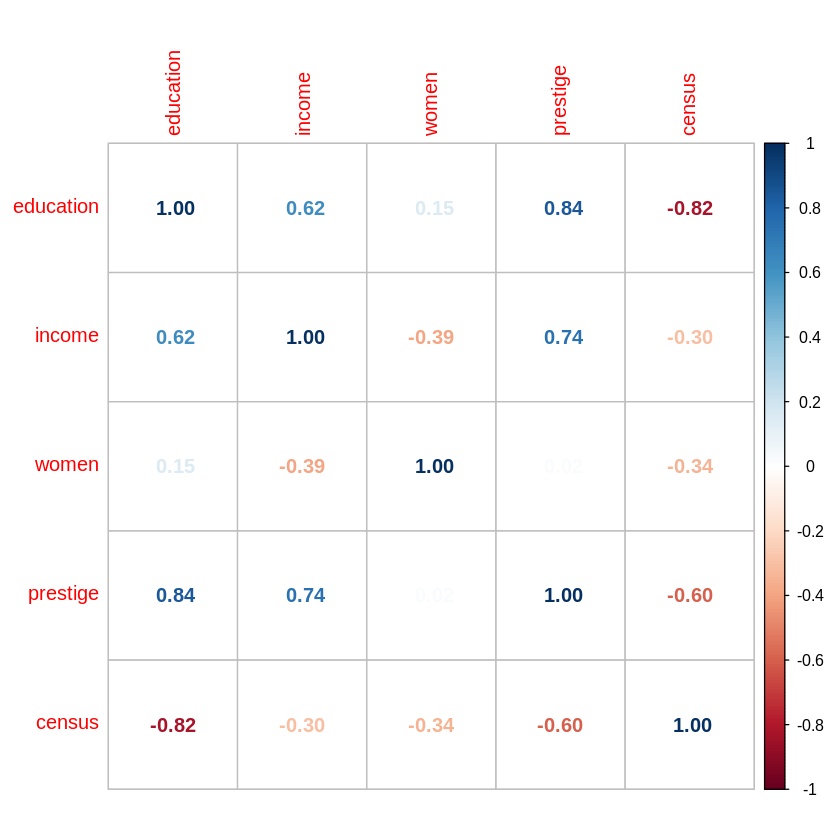

In [15]:
install.packages("corrplot")
library(corrplot)
corrplot(cor(train_data[,-6]) , method = "number") 

You can see hight correlation between `education ~ prestige`, `education ~ census`, `prestige ~ income`.

## 3.2. Visual analysis

Lets check data distribution of some variables 

Target/Output variable `prestige`:

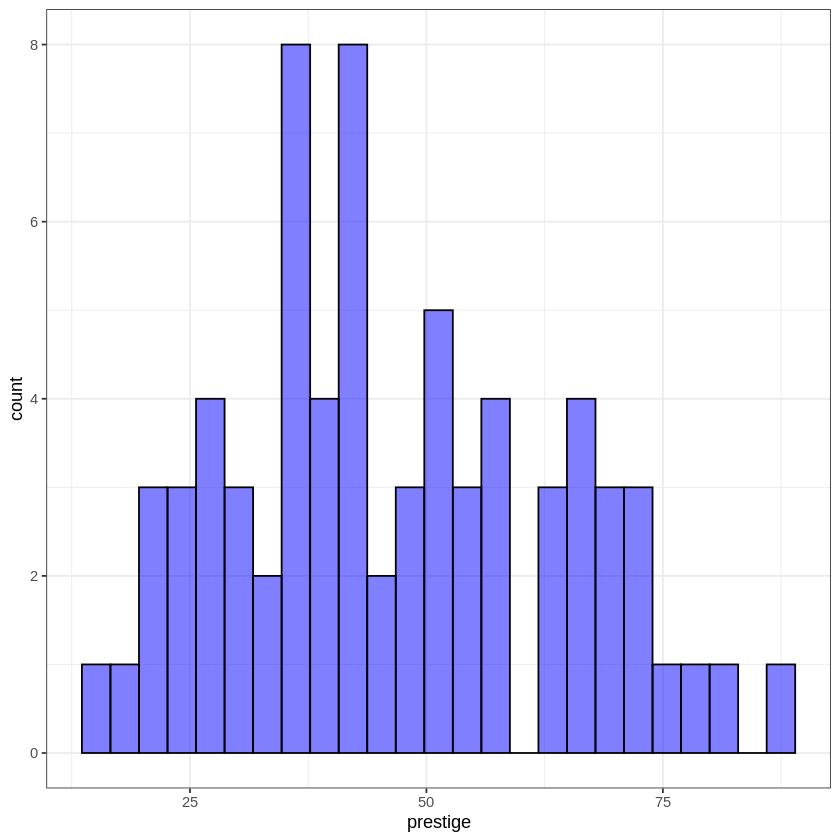

In [11]:
library(ggplot2)

ggplot(train_data, aes(prestige)) + 
    geom_histogram(bins = 25, alpha = 0.5, fill = 'blue', color='black')  + 
    theme_bw()

Input variable `income`:

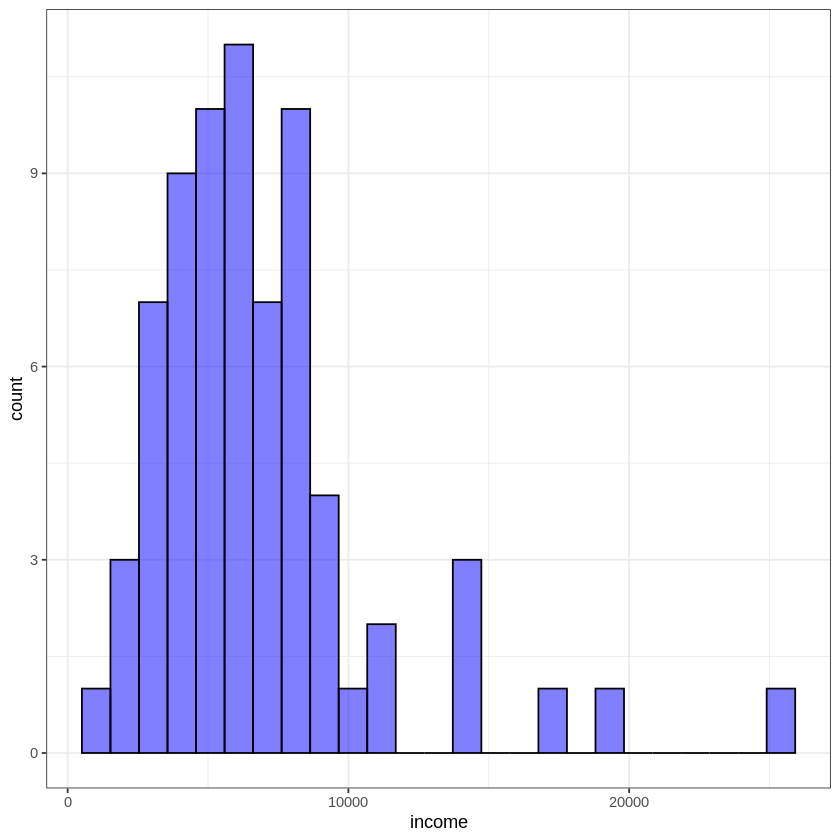

In [47]:
#ggplot(train_data, aes(log(income))) + 
ggplot(train_data, aes(income)) + 
    geom_histogram(bins = 25, alpha = 0.5, fill = 'blue', color='black')  + 
    theme_bw()

Input variable `women`:

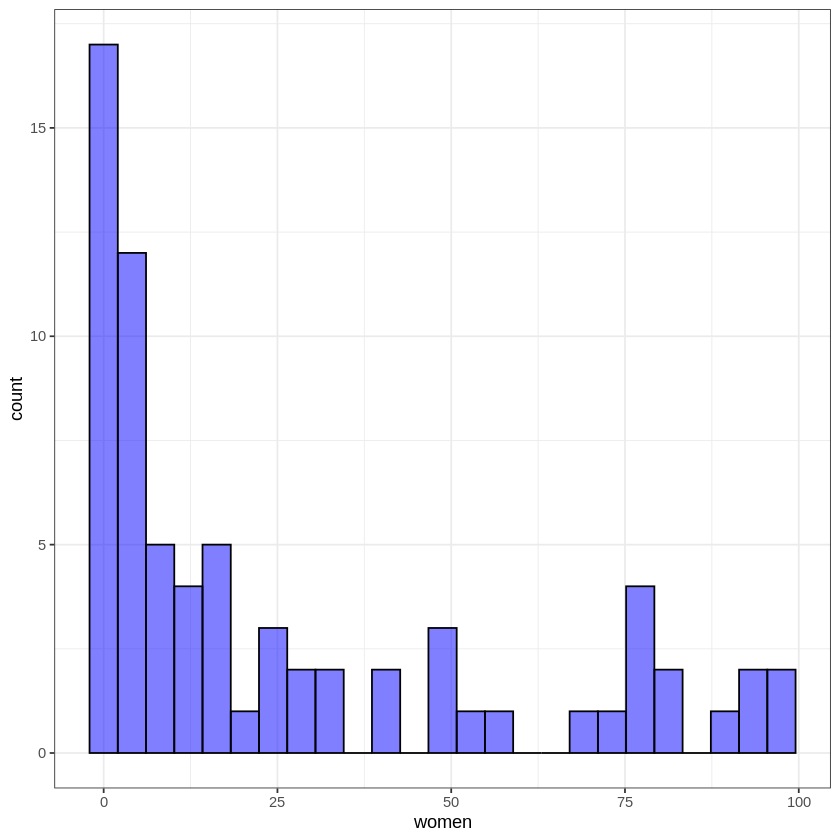

In [46]:
#ggplot(train_data, aes(log(women))) + 
ggplot(train_data, aes(women)) + 
    geom_histogram(bins = 25, alpha = 0.5, fill = 'blue', color='black')  + 
    theme_bw()

---

# 4. Model building

Функція `lm()` використовується для побудови лінійної регресії.

Syntax: `lm(formula, data = train_data)`

`formula` дозволяє вказати на залежність між вхідними та вихідним параметром. У даному випадку `prestige` - залежна змінна (`Y`), а усі, що після знаку `~` - незалежні (`X`).


In [28]:
lm_mod <- lm(formula = prestige ~ income + education, data = train_data)

Для детальнішого опису параметрів побудованої моделі варто скористатися функцією `summary()`:

In [29]:
summary(lm_mod)


Call:
lm(formula = prestige ~ income + education, data = train_data)

Residuals:
     Min       1Q   Median       3Q      Max 
-18.2951  -4.7988   0.1218   5.1932  17.1181 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -5.9237106  3.9637472  -1.494     0.14    
income       0.0014932  0.0003017   4.949 5.18e-06 ***
education    3.9135175  0.4460247   8.774 8.64e-13 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 8.035 on 68 degrees of freedom
Multiple R-squared:  0.7896,	Adjusted R-squared:  0.7834 
F-statistic: 127.6 on 2 and 68 DF,  p-value: < 2.2e-16


---

## Demo task: generating final formula for regression

Спробуємо створити рядковий вигляд для побудованої регресії (шляхом звичайного “склеювання” рядків). Це завдання для закріплення знань з алгоритмічного програмування в R.

In [31]:
lm_mod$coefficients # coefficients of the model

(Intercept)       income    education 
-5.923710650  0.001493228  3.913517546

In [35]:
getLmFormula <- function(lm_model) {
  
  str_formula <- paste(lm_model$terms[[2]], " = ", sep="")
  str_formula <- paste(str_formula, + round(lm_model$coefficients[1], 4), sep=" ")
  
  for(i in 2:length(lm_mod$coefficients)) {
    
    znak <- "+"
    if(lm_model$coefficients[i] < 0)
      znak <- "-"
    str_formula <- paste(str_formula, " ", znak, " ", round(lm_mod$coefficients[i], 4), "*", names(lm_mod$coefficients)[i] ,sep = "")
  }
  
  return(str_formula)
}

Тоді формулу можна отримати наступним чином:

In [36]:
str_formula <- getLmFormula(lm_mod)
print(str_formula)

[1] "prestige =  -5.9237 + 0.0015*income + 3.9135*education"


### END OF DEMO TASK

---

One more way to preview model info is using package `broom` nd function `tidy()`:

In [23]:
#install.packages("broom")
library(broom)

lm_mod_view <- tidy(lm_mod)
lm_mod_view

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),-5.923710650,3.9637471616,-1.494472,1.396785e-01
income,0.001493228,0.0003017277,4.948927,5.183124e-06
education,3.913517546,0.4460246832,8.774217,8.636723e-13


### Спробуємо змінити форму залежності і побудуємо модель на основі трансформованих показників. Скористаємося логарифмуванням незалежних змінних:

In [24]:
lm_mod2 <- lm(formula = prestige ~ log(income) + log(education), data = train_data)
summary(lm_mod2)


Call:
lm(formula = prestige ~ log(income) + log(education), data = train_data)

Residuals:
     Min       1Q   Median       3Q      Max 
-16.6827  -6.0052   0.3465   4.1241  17.4622 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)    -165.835     14.142 -11.727  < 2e-16 ***
log(income)      14.016      1.923   7.290 4.25e-10 ***
log(education)   38.615      4.094   9.433 5.62e-14 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 7.496 on 68 degrees of freedom
Multiple R-squared:  0.8169,	Adjusted R-squared:  0.8115 
F-statistic: 151.7 on 2 and 68 DF,  p-value: < 2.2e-16


$R^2$ зріс. Тобто зміна форми залежності може впливати на якість моделі. 

Alert! Its depends on our `seed` parameter, because of changing train and test sets.

Повернемося до попередньої моделі:

In [53]:
lm_mod <- lm(formula = prestige ~ income + education, data = train_data)

### Переглянемо графік реальних даних, прогнозованих та похибок. Для початку створимо тимчасовий data.frame для генерації графіка зі значень


- [x] фактори; 
- [x] реальні значення; 
- [x] прогнозовані значення; 
- [x] похибки.

Увага! Даний графік будуватимемо на тренувальній вибірці!

In [9]:
# data frame for storing data
tmp_data <- data.frame(education = train_data$education,
                       income = train_data$income,
                       prestige = train_data$prestige,
                       predicted = lm_mod$fitted.values,
                       residuals = lm_mod$residuals) 

Переглянемо залежності між параметрами моделі:

In [10]:
# prestige vs education
ggplot(tmp_data, aes(x = education, y = prestige)) +
  geom_segment(aes(xend = education, yend = predicted), alpha = .2) +
  geom_point(aes(), color = 'blue') +
  #scale_color_gradient2(low = "blue", mid = "white", high = "red") +
  #guides(color = FALSE) +
  geom_point(aes(y = predicted), shape = 2) +
  theme_bw()

ERROR: Error in ggplot(tmp_data, aes(x = education, y = prestige)): could not find function "ggplot"


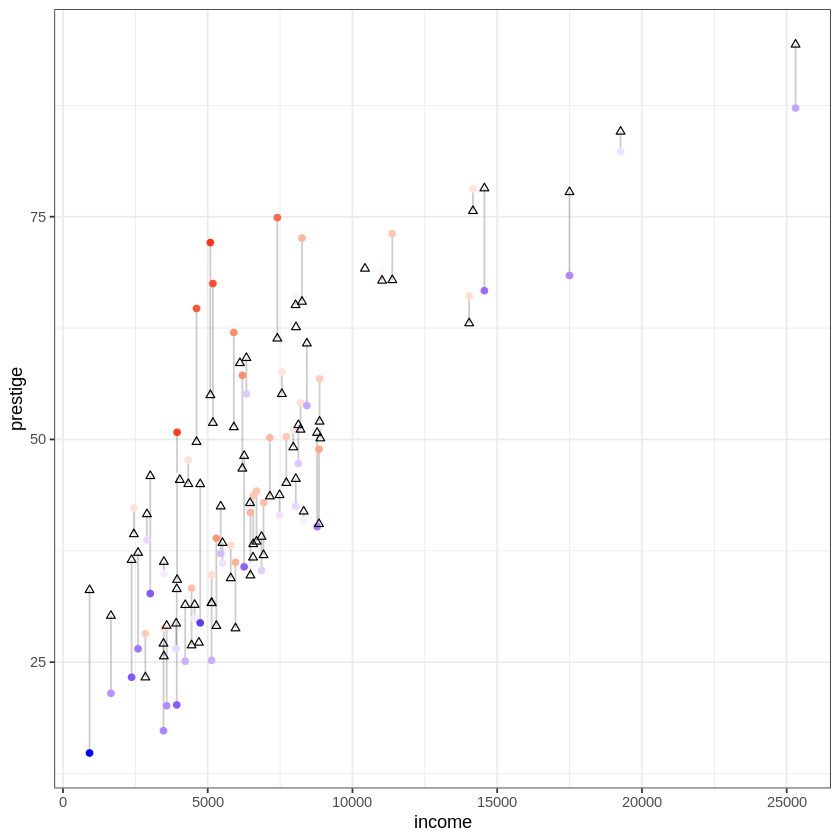

In [14]:
# prestige vs income
ggplot(tmp_data, aes(x = income, y = prestige)) +
  geom_segment(aes(xend = income, yend = predicted), alpha = .2) +
  geom_point(aes(color = residuals)) +
  scale_color_gradient2(low = "blue", mid = "white", high = "red") +
  guides(color = FALSE) +
  geom_point(aes(y = predicted), shape = 2) +
  theme_bw()


# 5. Prediction on test data and accuracy

Здійснимо прогноз за допомогою функції `predict()`.

In [51]:
library(dplyr)

test_predicted <- predict(lm_mod, test_data)

summary(test_predicted)
as.data.frame(sort(test_predicted) %>% head())

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  25.41   35.05   44.34   46.39   55.54   85.79 

,sort(test_predicted) %>% head()
,<dbl>
farmers,25.40565
canners,28.43229
launderers,30.01486
cooks,30.56504
bakers,30.72836
bus.drivers,31.92421


`MSE` (`Mean Squared Error`) – середньоквадратичне відхилення; середнє значення квадратів відхилень прогнозованих даних від реальних.

In [30]:
mse <- mean((test_data$prestige - test_predicted)^2)
mse

[1] 55.24585

`MAPE`. `MAPE (Mean Absolute Percentage Error)` – середнє абсолютне відхилення прогнозованого показника від реального:

In [31]:
mape <- mean(abs(test_data$prestige - test_predicted)/test_data$prestige)
mapedd

[1] 0.1344248

Обчислимо метрики моделі за допомогою пакету `modelr` та функцій з нього:

In [48]:
install.packages("modelr")
library(modelr)
data.frame(
  R2 = rsquare(lm_mod, data = test_data),
  MSE = mse(lm_mod, data = test_data),
  RMSE = rmse(lm_mod, data = test_data),
  MAE = mae(lm_mod, data = test_data),
  MAPE = mape(lm_mod, data = test_data)
)

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



R2,MSE,RMSE,MAE,MAPE
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.8219865,55.24585,7.432755,6.139407,0.1344248


Mae - Mean Absolute Error. 
Rmse - Root mean squared error. Детальніше: https://medium.com/human-in-a-machine-world/mae-and-rmse-which-metric-is-better-e60ac3bde13d.

### Перевірка на мультиколінераність

In [47]:
install.packages("car")

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



Well done! There are no multicolinearity.

Зафіксуємо значення R^2 для моделі у деякій змінній:

In [56]:
r_sq = rsquare(lm_mod, data = test_data)
r_sq 

[1] 0.8219865

Як видно вище тут мультиколінеарність відсутня.

Введемо в модель додатковий показник, що буде явно залежати від одного з факторів:

In [93]:
lm_mod2 <- lm(formula = prestige ~ income + education + income_2, data = train_data)
summary(lm_mod2)
rsquare(lm_mod2, data = train_data)


Call:
lm(formula = prestige ~ income + education + income_2, data = train_data)

Residuals:
    Min      1Q  Median      3Q     Max 
-15.732  -4.900  -0.057   4.598  18.459 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -1.135e+01  3.272e+00  -3.470 0.000775 ***
income       3.294e-03  5.669e-04   5.810 7.79e-08 ***
education    3.809e+00  3.407e-01  11.179  < 2e-16 ***
income_2    -7.967e-08  2.169e-08  -3.673 0.000390 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 7.36 on 98 degrees of freedom
Multiple R-squared:  0.8224,	Adjusted R-squared:  0.817 
F-statistic: 151.3 on 3 and 98 DF,  p-value: < 2.2e-16


[1] 0.8224462

In [88]:
r_sq2 <- rsquare(lm_mod2, data = test_data)
r_sq
r_sq2

[1] 0.8219865

[1] 0.9674058

VIF-тест для моделі із корельованими змінними:

In [94]:
vif(lm_mod2)

income education  income_2 
10.805325  1.611593  9.241780

The best way is to exclude the biggest and rebuild model in this case. 

# 6. Extending model

Додамо до моделі категоріальний параметр type. Переглянемо можливі варіанти значень:

In [71]:
unique(train_data$type)

[1] prof bc   wc   <NA>
Levels: bc prof wc

So, its a factor. with 3 values and missing data (NA).

Lets build new model with `type`:

In [96]:
lm_mod <- lm(formula = prestige ~ income + education + type, data = train_data)
summary(lm_mod)


Call:
lm(formula = prestige ~ income + education + type, data = train_data)

Residuals:
     Min       1Q   Median       3Q      Max 
-14.9529  -4.4486   0.1678   5.0566  18.6320 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.6229292  5.2275255  -0.119    0.905    
income       0.0010132  0.0002209   4.586 1.40e-05 ***
education    3.6731661  0.6405016   5.735 1.21e-07 ***
typeprof     6.0389707  3.8668551   1.562    0.122    
typewc      -2.7372307  2.5139324  -1.089    0.279    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 7.095 on 93 degrees of freedom
  (4 observations deleted due to missingness)
Multiple R-squared:  0.8349,	Adjusted R-squared:  0.8278 
F-statistic: 117.5 on 4 and 93 DF,  p-value: < 2.2e-16


З’явилися нові показники `typeprof` та `typewc`. Вони згенеровані автоматично як `dummy`-змінні функцією `lm()`. Якщо Ви хочете переглянути усі показники, що приймали участь у побудові моделі, то можна викликати $model:

In [97]:
lm_mod$model %>% head()

,prestige,income,education,type
,<dbl>,<int>,<dbl>,<fct>
gov.administrators,68.8,12351,13.11,prof
general.managers,69.1,25879,12.26,prof
accountants,63.4,9271,12.77,prof
purchasing.officers,56.8,8865,11.42,prof
chemists,73.5,8403,14.62,prof
physicists,77.6,11030,15.64,prof


In [43]:
# for better view as html table use DT package
#install.packages("DT")
library(DT)
datatable(lm_mod$model)

HTML widgets cannot be represented in plain text (need html)

---

# 7. Model errors 

Переглянемо характеристики моделі:

In [98]:
lm_mod <- lm(formula = prestige ~ income + education + type, data = train_data)
summary(lm_mod)


Call:
lm(formula = prestige ~ income + education + type, data = train_data)

Residuals:
     Min       1Q   Median       3Q      Max 
-14.9529  -4.4486   0.1678   5.0566  18.6320 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.6229292  5.2275255  -0.119    0.905    
income       0.0010132  0.0002209   4.586 1.40e-05 ***
education    3.6731661  0.6405016   5.735 1.21e-07 ***
typeprof     6.0389707  3.8668551   1.562    0.122    
typewc      -2.7372307  2.5139324  -1.089    0.279    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 7.095 on 93 degrees of freedom
  (4 observations deleted due to missingness)
Multiple R-squared:  0.8349,	Adjusted R-squared:  0.8278 
F-statistic: 117.5 on 4 and 93 DF,  p-value: < 2.2e-16


Сформуємо розмітку для виведення графіків 4-х графіків одразу (2*2):

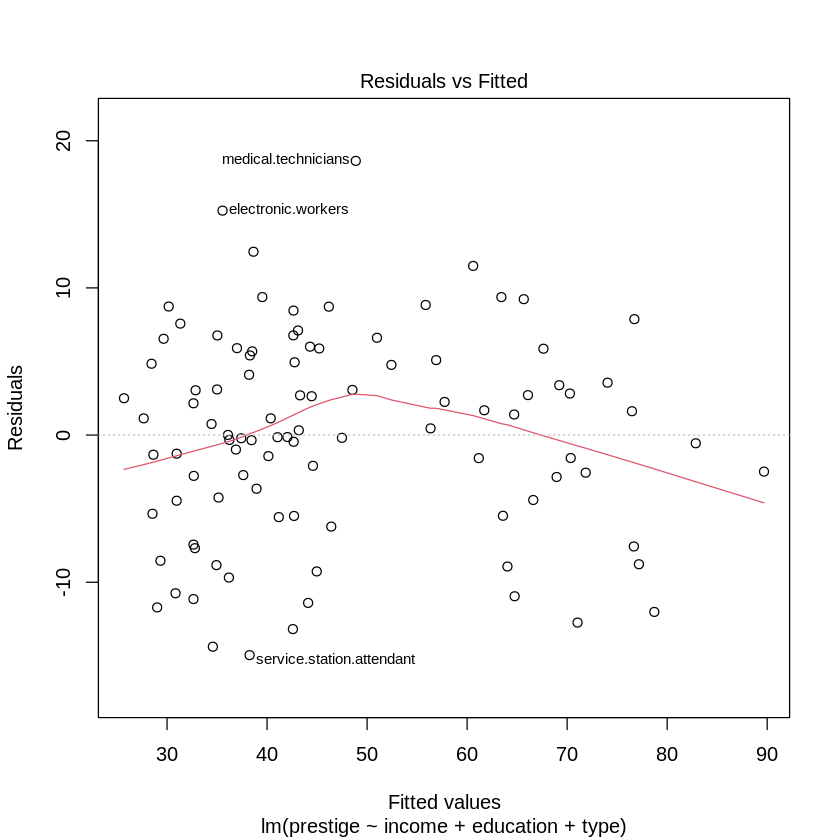

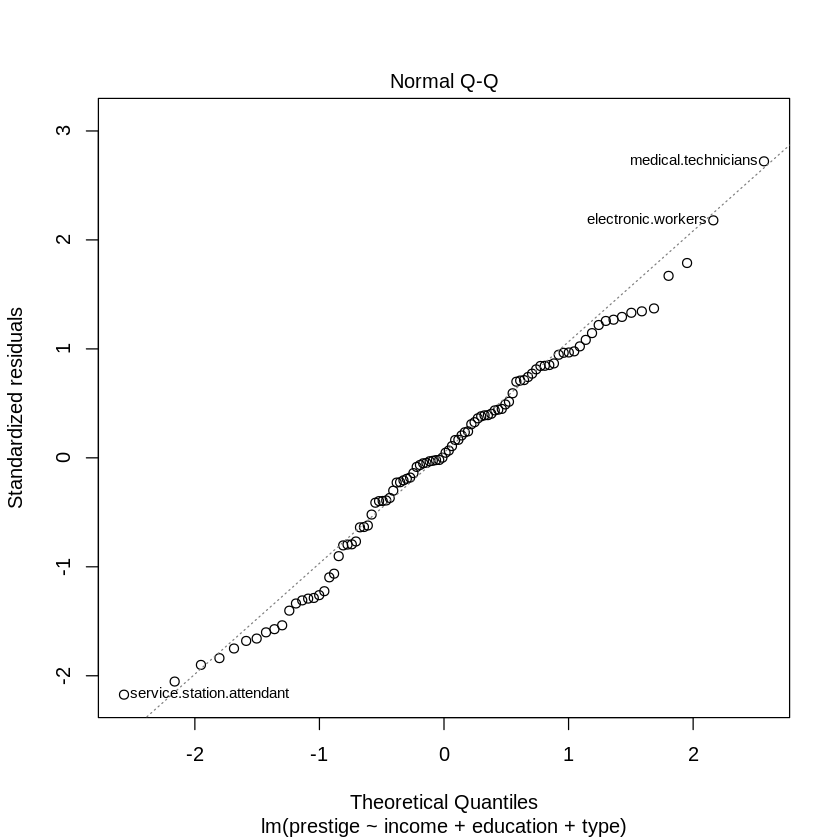

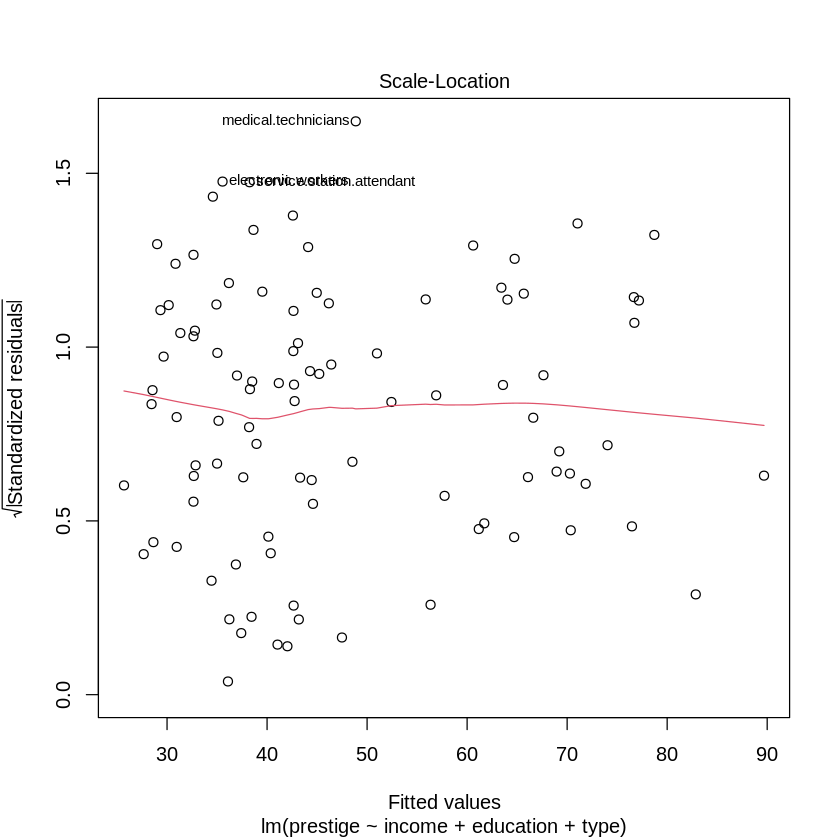

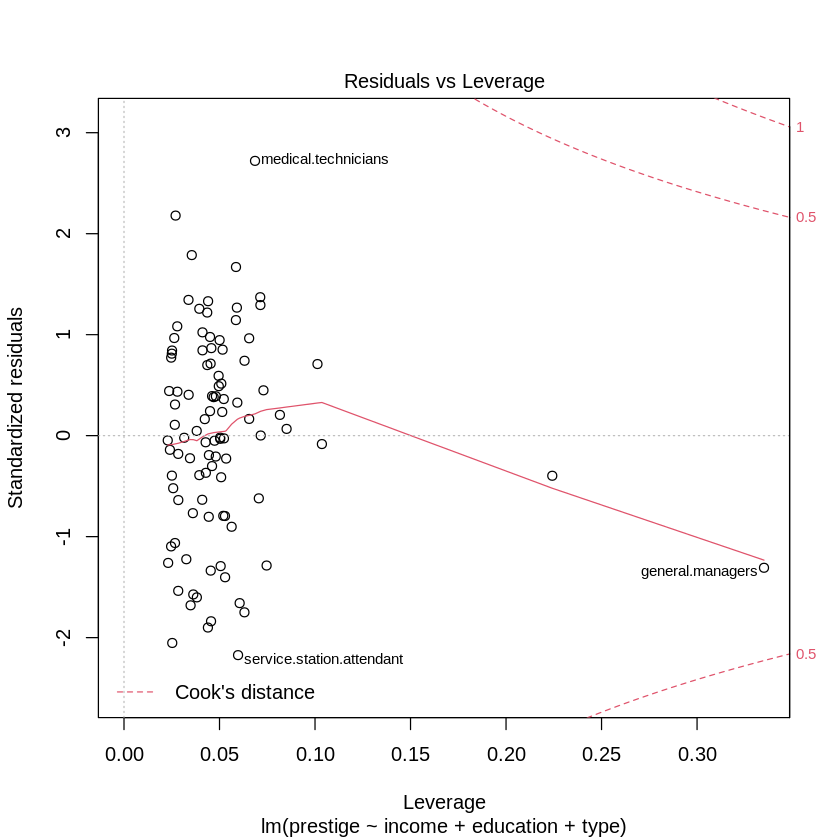

In [99]:
#par(mfrow=c(2,2))
plot(lm_mod)

На двох графіках зліва червона лінія показує середнє з відхилень. Якщо варіація похибок зростає разом із збільшенням значень прогнозу - це називається гетероскедастичніть. Прогнозування за таких умов буде давати спотворені результати. Переконаємося у відсутності гетероскедастичності перевіривши `p-value`:

In [101]:
#install.packages("lmtest")
library(lmtest)
bptest(lm_mod)


	studentized Breusch-Pagan test

data:  lm_mod
BP = 7.0719, df = 4, p-value = 0.1321


`p-value > 0.05`, отже ми відхиляємо гіпотезу про те, що гетероскедастичність відсутня (залишки гомоскедастичні - мають однакову дисперсію).

`Normal QQ`-графік дозволяє перевірити чи похибки розподілені за нормальним законом розподілу. Ідеальний варіант коли вони розміщені чітко по діагональній лінії.

На останньому графіку показується як кожне значення впливає на регресію. У статистиці відстань Кука є загальноприйнятою оцінкою впливу спостереження під час застосування методу найменших квадратів у регресійному аналізі.На практиці, при застосуванні методу найменших квадратів, відстань Кука може використовуватися для наступних цілей: визначити впливові спостереження даних, які потрібно перевірити на валідність; визначення областей простору, у яких непогано було б отримати більше результатів спостереження. Джерело: Detection of Influential Observation in Linear Regression / R. Dennis Cook (https://www.jstor.org/stable/1268249?origin=crossref&seq=1)

Повернемо розмітку для 1-го графіка у вікні RStudio:

In [54]:
par(mfrow=c(1,1))

Переглянемо розподіл похибок:

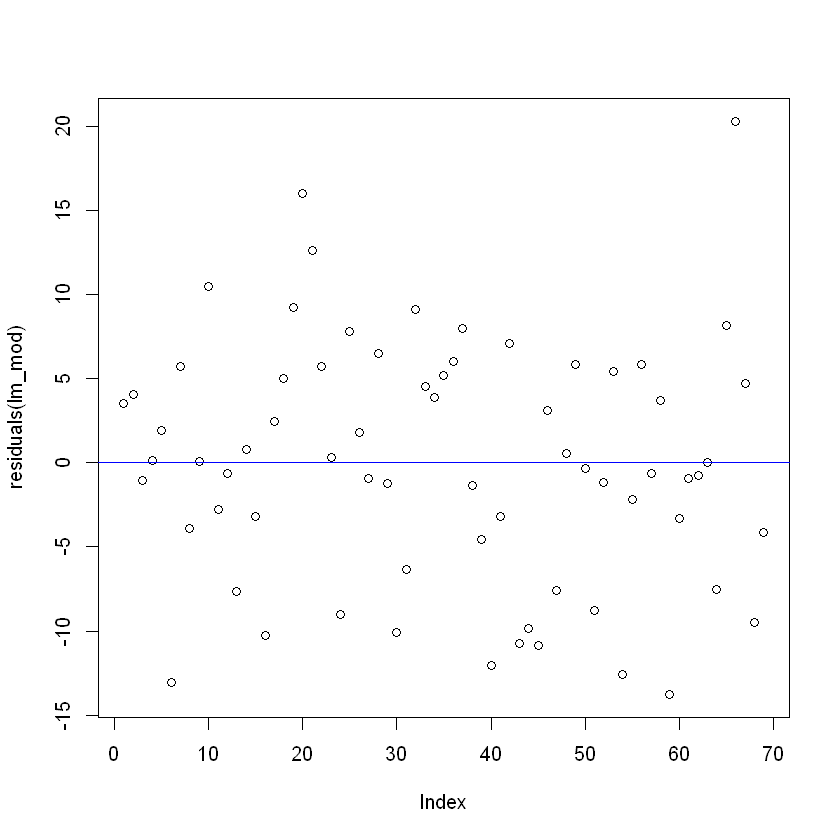

In [56]:
plot(residuals(lm_mod)) 
abline(a=0,b=0,col='blue')

Візуальних закономірностей у похибках немає. Схоже, що вони мають випадковий характер.

---

# 8. Features selection

Ручний відбір параметрів моделі має ряд недоліків, що пов’язані із якістю моделі та затратами часу на її побудову. Вивчимо окремі алгоритми автоматизованого відбору параметрів у модель.

## 8.1. BestSubsets method

Метод `BestSubsets` також відомий як `all possible regressions`. Цей метод відповідно до назв будує всі можливі варіанти моделей на незалежних змінних. Кількість моделей становить $2^p$, де $p$ - кількість неазелжних змінних, так для 10 вхідних параметрів буде побудовано $2^10 =1024$ моделей.

In [106]:
library(leaps)
best_subsets_mod <- regsubsets(prestige ~ income + education + type + women, data = train_data)

Розгялнемо відібрані параметри моделі BestSubsets. По осі `Y` розміщені значення `BIC`, який обраний як якісний показник регресії, по `X` - параметри моделі:

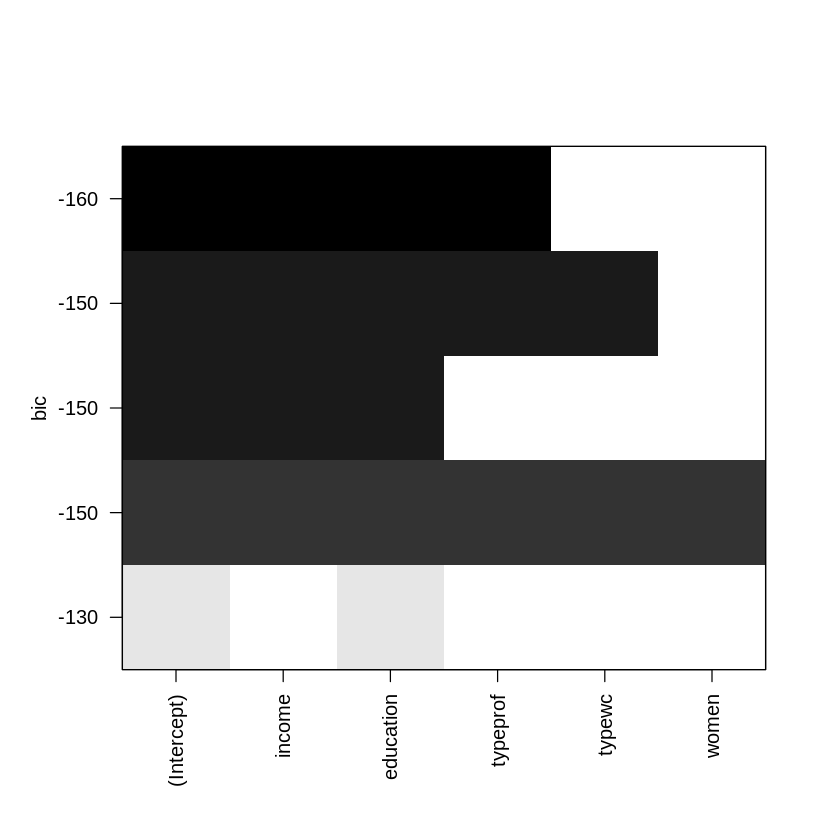

In [108]:
plot(best_subsets_mod)

Найтемніша лінія вказує на найкращу модель.

Перебудуємо модель для усіх можливих варіантів комбінацій параметрів:

In [119]:
best_subsets_mod <- regsubsets(prestige ~ income + education + type + women, data = train_data)

Також можемо обрати кращу модель окремо за критеріями, наприклад скоригований $R^2$:

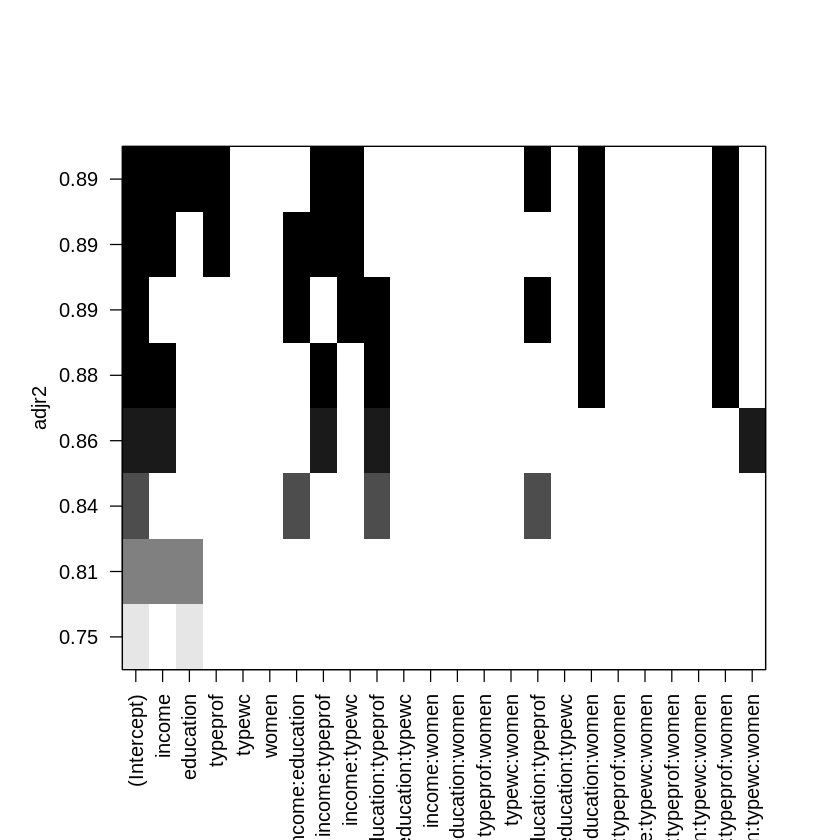

In [122]:
plot(best_subsets_mod, scale = "adjr2")

Моделі з найвищим $R^2$ обираються у такому випадку за цим критерієм, проте не варто забувати про появу мультиколінеарності.

In [191]:
results <- summary(best_subsets_mod)
model_index <- which.max(results$adjr2)
t <- m$which[model_index, ]
as.data.frame(t) %>% filter(t)

,t
,<lgl>
(Intercept),TRUE
income,TRUE
education,TRUE
typeprof,TRUE
income:typeprof,TRUE
income:typewc,TRUE
income:education:typeprof,TRUE
income:education:women,TRUE
income:education:typeprof:women,TRUE


So, the best regression by Adjusted R-Squared is 

```a0 + a1*income + a2*typeprof + a3*income:typeprof + a4*education:women + a5*income:education:typeprof + a6*income:typeprof:women + a7*income:typewc:women + a8*income:education:typewc:women```

---

## 8.2. Stepwise method

Stepwise - метод, що перебирає можливі варіанти та повертає найкращу модель з найнижчим показником AIC. Перебір моделі може бути з виключенням або з включенням показників у модель - у обох напрямках.

Для початку очистимо дані, що мають пропуски у полі type (також ці дані можна заповнити).

In [194]:
nrow(train_data)
train_data <- train_data[!is.na(train_data$type), ]
nrow(train_data)

[1] 98

[1] 98

Найпростіша модель з одним параметром (першим по списку) матиме вигляд:

In [195]:
start_mod <- lm(prestige ~ 1, data = train_data)

Модель з усіма параметрами:

In [196]:
end_mod <- lm(prestige ~ ., data = train_data)

Запустимо алгоритм функцією `step()`:

In [197]:
stepwise_mod <- step(start_mod, 
                     # set minimum and maximum parameters
                     scope = list(lower = start_mod, upper = end_mod),
                     # direction of model building
                     direction = "both", trace = 1, steps = 1000)
                     # c("both", "backward", "forward") - possible directions

Start:  AIC=557.4
prestige ~ 1

            Df Sum of Sq     RSS    AIC
+ education  1   21282.5  7064.4 423.23
+ type       2   19775.6  8571.3 444.18
+ income     1   14021.6 14325.3 492.51
+ census     1   11945.3 16401.6 505.78
+ income_2   1    9221.0 19125.9 520.84
<none>                   28346.9 557.40
+ women      1     343.9 28003.0 558.20

Step:  AIC=423.23
prestige ~ education

            Df Sum of Sq     RSS    AIC
+ income     1    1792.0  5272.4 396.56
+ type       2    1324.4  5740.0 406.89
+ income_2   1    1010.2  6054.2 410.11
+ women      1     763.5  6300.9 414.02
+ census     1     394.6  6669.9 419.60
<none>                    7064.4 423.23
- education  1   21282.5 28346.9 557.40

Step:  AIC=396.56
prestige ~ education + income

            Df Sum of Sq     RSS    AIC
+ income_2   1     504.2  4768.2 388.71
+ type       2     591.2  4681.3 388.90
<none>                    5272.4 396.56
+ census     1      96.8  5175.6 396.74
+ women      1      10.4  5262.1 398.

In [198]:
# lets see the summary
summary(stepwise_mod)


Call:
lm(formula = prestige ~ education + income + income_2 + type + 
    women, data = train_data)

Residuals:
     Min       1Q   Median       3Q      Max 
-14.4409  -3.7034  -0.2846   4.5841  17.7097 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -7.127e+00  5.246e+00  -1.359  0.17764    
education    2.741e+00  6.496e-01   4.219 5.79e-05 ***
income       3.994e-03  8.118e-04   4.919 3.84e-06 ***
income_2    -1.012e-07  2.653e-08  -3.812  0.00025 ***
typeprof     6.209e+00  3.677e+00   1.688  0.09474 .  
typewc      -2.521e+00  2.491e+00  -1.012  0.31423    
women        8.430e-02  3.495e-02   2.412  0.01787 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 6.659 on 91 degrees of freedom
Multiple R-squared:  0.8577,	Adjusted R-squared:  0.8483 
F-statistic: 91.39 on 6 and 91 DF,  p-value: < 2.2e-16


> З підсумків моделі видно, що детермінація зросла, тобто модель стала описувати явище ще краще.

---

## References